## To what extent does exactly minimizing risk correspond to accurate support recovery? Does the extent of this correspondence differ between evaluation on the train vs. test set?

In [1]:
%load_ext autoreload
%autoreload 2
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import time
import pdb

sys.path.append('..')

from utils import gen_covariance, gen_beta2, gen_data, get_cov_list
from utils import selection_accuracy
from sklearn.linear_model import LassoLars, lasso_path

from pyuoi.linear_model import UoI_Lasso

#### First fit to a model without correlations

In [2]:
sigma = gen_covariance(100, 0, 100, 1, 0)
beta = gen_beta2(100, 100, 0.2)
X, X_test, y, y_test, ss = gen_data(300, 100, covariance = sigma, beta = beta)

In [3]:
uoil = UoI_Lasso(estimation_score = 'AIC')
uoil.fit(X, y)

UoI_Lasso(comm=None, copy_X=True, eps=0.001, estimation_frac=0.9,
     estimation_score='AIC', fit_intercept=True, max_iter=None,
     n_boots_est=48, n_boots_sel=48, n_lambdas=48, normalize=True,
     random_state=<module 'numpy.random' from 'C:\\Users\\akumar\\Anaconda3\\envs\\nse\\lib\\site-packages\\numpy\\random\\__init__.py'>,
     selection_frac=0.9, stability_selection=1.0, warm_start=None)

#### Calculate the exact risk of incurred by each estimate, as well as the corresponding selection accuracy

In [4]:
estimates = uoil.estimates_.reshape((-1, 100))
selection_accuracies = selection_accuracy(beta.ravel(), estimates)

In [5]:
from risk import calc_KL_div

In [6]:
# Calculation of exact KL divergence
KL_divs = np.zeros(selection_accuracies.size)
for i in range(estimates.shape[0]):
    
    beta_hat = estimates[i, :]
    
    sigma_hat = np.mean((y.ravel() - X @ beta_hat.ravel())**2)
        
    KL_divs[i] = calc_KL_div(X @ beta_hat, np.sqrt(sigma_hat), np.sqrt(ss))
    

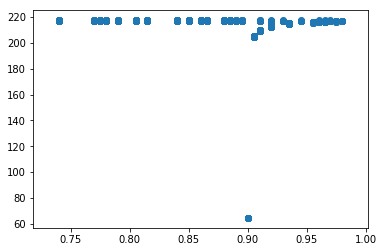

In [7]:
plt.scatter(selection_accuracies, KL_divs) 

In [10]:
selection_accuracy(beta.ravel(), uoil.coef_)

array([0.855])

In [8]:
from risk import AIC

In [11]:
# Verify our calculation. Calculate the AIC and the true KL divergence as n -> infinity
n_samples = [300, 1000, 3000, 10000, 30000, 100000, 300000]

sigma = gen_covariance(100, 0, 100, 1, 0)
beta = gen_beta2(100, 100, 0.2)

uoil = UoI_Lasso(estimation_score = 'AIC')

AIC_scores = []
exact_risk = []

for i, n_samples_ in enumerate(n_samples):
    # Generate data
    X, X_test, y, y_test, ss = gen_data(n_samples_, 100, covariance = sigma, beta = beta)
    
    # Fit
    uoil.fit(X, y)
    
    # Calculate AIC
    estimates = uoil.estimates_.reshape((-1, 100))
    
    AIC_scores_ = np.zeros(estimates.shape[0])

    # True risk
    exact_risk_ = np.zeros(estimates.shape[0])
    
    for j in range(estimates.shape[0]):
        beta_hat = estimates[j, :]
        sigma_hat = np.mean((y.ravel() - X @ beta_hat.ravel())**2)

        AIC_scores_[j] = AIC(y, X_test @ beta_hat, 100)

        exact_risk_[j] = calc_KL_div(X @ beta_hat, np.sqrt(sigma_hat), np.sqrt(ss))

    AIC_scores.append(AIC_scores_)
    exact_risk.append(exact_risk_)


MemoryError: 

In [ ]:
# Does the AIC asymptotically approximate the true error?
# How about a single leave k out estimate?

# How does this asymptotic behavior vary as a function of the sparsity of the underlying model?